In [251]:
import copy
from math import ceil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [252]:
demo = pd.read_csv("D:/datasets/HousingPrices-Amsterdam-August-2021.csv", index_col=0)
df = copy.deepcopy(demo)

In [253]:
df.head()

,Address,Zip,Price,Area,Room,Lon,Lat
1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538


In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 924 entries, 1 to 924
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  924 non-null    object 
 1   Zip      924 non-null    object 
 2   Price    920 non-null    float64
 3   Area     924 non-null    int64  
 4   Room     924 non-null    int64  
 5   Lon      924 non-null    float64
 6   Lat      924 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 57.8+ KB


In [255]:
df.describe()

,Price,Area,Room,Lon,Lat
count,9.200000e+02,924.000000,924.000000,924.000000,924.000000
mean,6.220654e+05,95.952381,3.571429,4.888605,52.363326
std,5.389942e+05,57.447436,1.592332,0.053140,0.024028
min,1.750000e+05,21.000000,1.000000,4.644819,52.291519
25%,3.500000e+05,60.750000,3.000000,4.855834,52.352077
50%,4.670000e+05,83.000000,3.000000,4.886818,52.364631
75%,7.000000e+05,113.000000,4.000000,4.922337,52.377598
max,5.950000e+06,623.000000,14.000000,5.029122,52.423805


In [256]:
df.isnull().sum()

Address    0
Zip        0
Price      4
Area       0
Room       0
Lon        0
Lat        0
dtype: int64

### EDA

### Feature engineering

#### Address Column

In [257]:
# to extract street from address
df['Street'] = df['Address'].str.extract(r'^(\D+)').apply(lambda x: x.str.strip().str.replace(' ','_'))
df.head()

,Address,Zip,Price,Area,Room,Lon,Lat,Street
1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157,Blasiusstraat
2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586,Kromme_Leimuidenstraat
3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782,Zaaiersweg
4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712,Tenerifestraat
5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538,Winterjanpad


In [258]:
df[df['Street'].isna()==True]

,Address,Zip,Price,Area,Room,Lon,Lat,Street
48,"1e Kekerstraat 77 PP, Amsterdam",1104 VA,325000.0,99,3,4.981149,52.314000,NaN
588,"1e Kekerstraat 119, Amsterdam",1104 VA,295000.0,91,3,4.981371,52.313749,NaN


In [259]:
df['Street'] = df['Street'].fillna('Kekerstraat')

In [260]:
df.drop('Address', axis=1, inplace=True)

#### Price column

##### NAs in Price column is filled the mean of values of dataset which is grouped by Street column. 

In [261]:
# Filling NA in Price column
mean_price_by_street = df.groupby('Street')['Price'].mean()
df['Price'] = df['Price'].fillna(df['Street'].map(mean_price_by_street))

In [262]:
# some rows are unique, and don't have price
df[df['Price'].isna()==True]

,Zip,Price,Area,Room,Lon,Lat,Street
74,1017 VV,NaN,147,3,4.897454,52.360707,Falckstraat
611,1019 HT,NaN,107,3,4.945022,52.369244,Zeeburgerkade
728,1013 CK,NaN,81,3,4.880976,52.389623,Suikerplein


[]

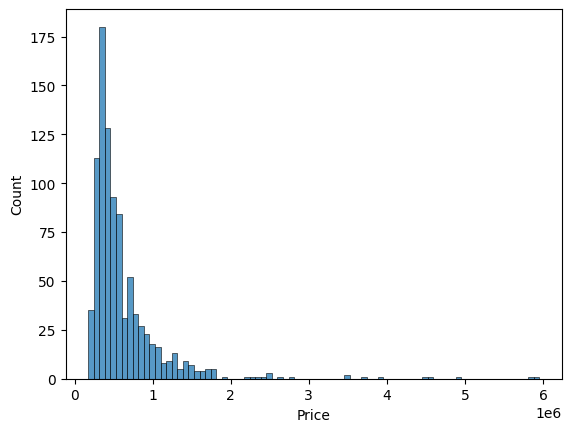

In [263]:
sns.histplot(df['Price'])
plt.plot()

In [264]:
df['Price'] = df['Price'].fillna(df['Price'].mean())

##### Values of Price column is rewritten using decimal point shifting

In [265]:
df['Price'] = df['Price'].apply(lambda x: x/1000)

In [266]:
df.isna().sum()

Zip       0
Price     0
Area      0
Room      0
Lon       0
Lat       0
Street    0
dtype: int64

#### Zip column

In [267]:
df['Zip'] = df['Zip'].str[0:4]
df.head()

,Zip,Price,Area,Room,Lon,Lat,Street
1,1091,685.0,64,3,4.907736,52.356157,Blasiusstraat
2,1059,475.0,60,3,4.850476,52.348586,Kromme_Leimuidenstraat
3,1097,850.0,109,4,4.944774,52.343782,Zaaiersweg
4,1060,580.0,128,6,4.789928,52.343712,Tenerifestraat
5,1036,720.0,138,5,4.902503,52.410538,Winterjanpad


In [268]:
# district groups 
zip_district = pd.DataFrame(np.array([
    [1011, 1018, 1], [1019, 1019, 2], [1020, 1029, 3],
    [1030, 1039, 4], [1040, 1049, 5], [1050, 1059, 6], 
    [1060, 1069, 7], [1070, 1083, 8], [1086, 1099, 9], 
    [1100, 1108, 10], [1109, 1109, 11]]), 
    columns = ['low', 'upper', 'dstrc_code'])

zip_district

,low,upper,dstrc_code
0,1011,1018,1
1,1019,1019,2
2,1020,1029,3
3,1030,1039,4
4,1040,1049,5
5,1050,1059,6
6,1060,1069,7
7,1070,1083,8
8,1086,1099,9
9,1100,1108,10


In [269]:
df['Zip'] = df['Zip'].astype(np.float64)

In [270]:
### create district column
df['Zip_Area'] = df['Zip'].apply( lambda x: zip_district.loc[(zip_district['low'] <= x) & (zip_district['upper'] >= x), 'dstrc_code'].values[0])
df.drop('Zip', axis=1, inplace=True)
df.head()

,Price,Area,Room,Lon,Lat,Street,Zip_Area
1,685.0,64,3,4.907736,52.356157,Blasiusstraat,9
2,475.0,60,3,4.850476,52.348586,Kromme_Leimuidenstraat,6
3,850.0,109,4,4.944774,52.343782,Zaaiersweg,9
4,580.0,128,6,4.789928,52.343712,Tenerifestraat,7
5,720.0,138,5,4.902503,52.410538,Winterjanpad,4


In [271]:
# place Price column at the end
df = df[list(df.columns.drop('Price')) + ['Price']]

#### Encoding

In [272]:
cat_cols = [cname for cname in df.columns if df[cname].dtype=='O']
df[cat_cols].nunique()

Street    624
dtype: int64

In [273]:
# Other than Target Encoder, other encoding methods are not suitable for 624 unique values
from category_encoders import TargetEncoder

encoder = TargetEncoder(cols = ['Street'])
df = encoder.fit_transform(df, df['Price'])

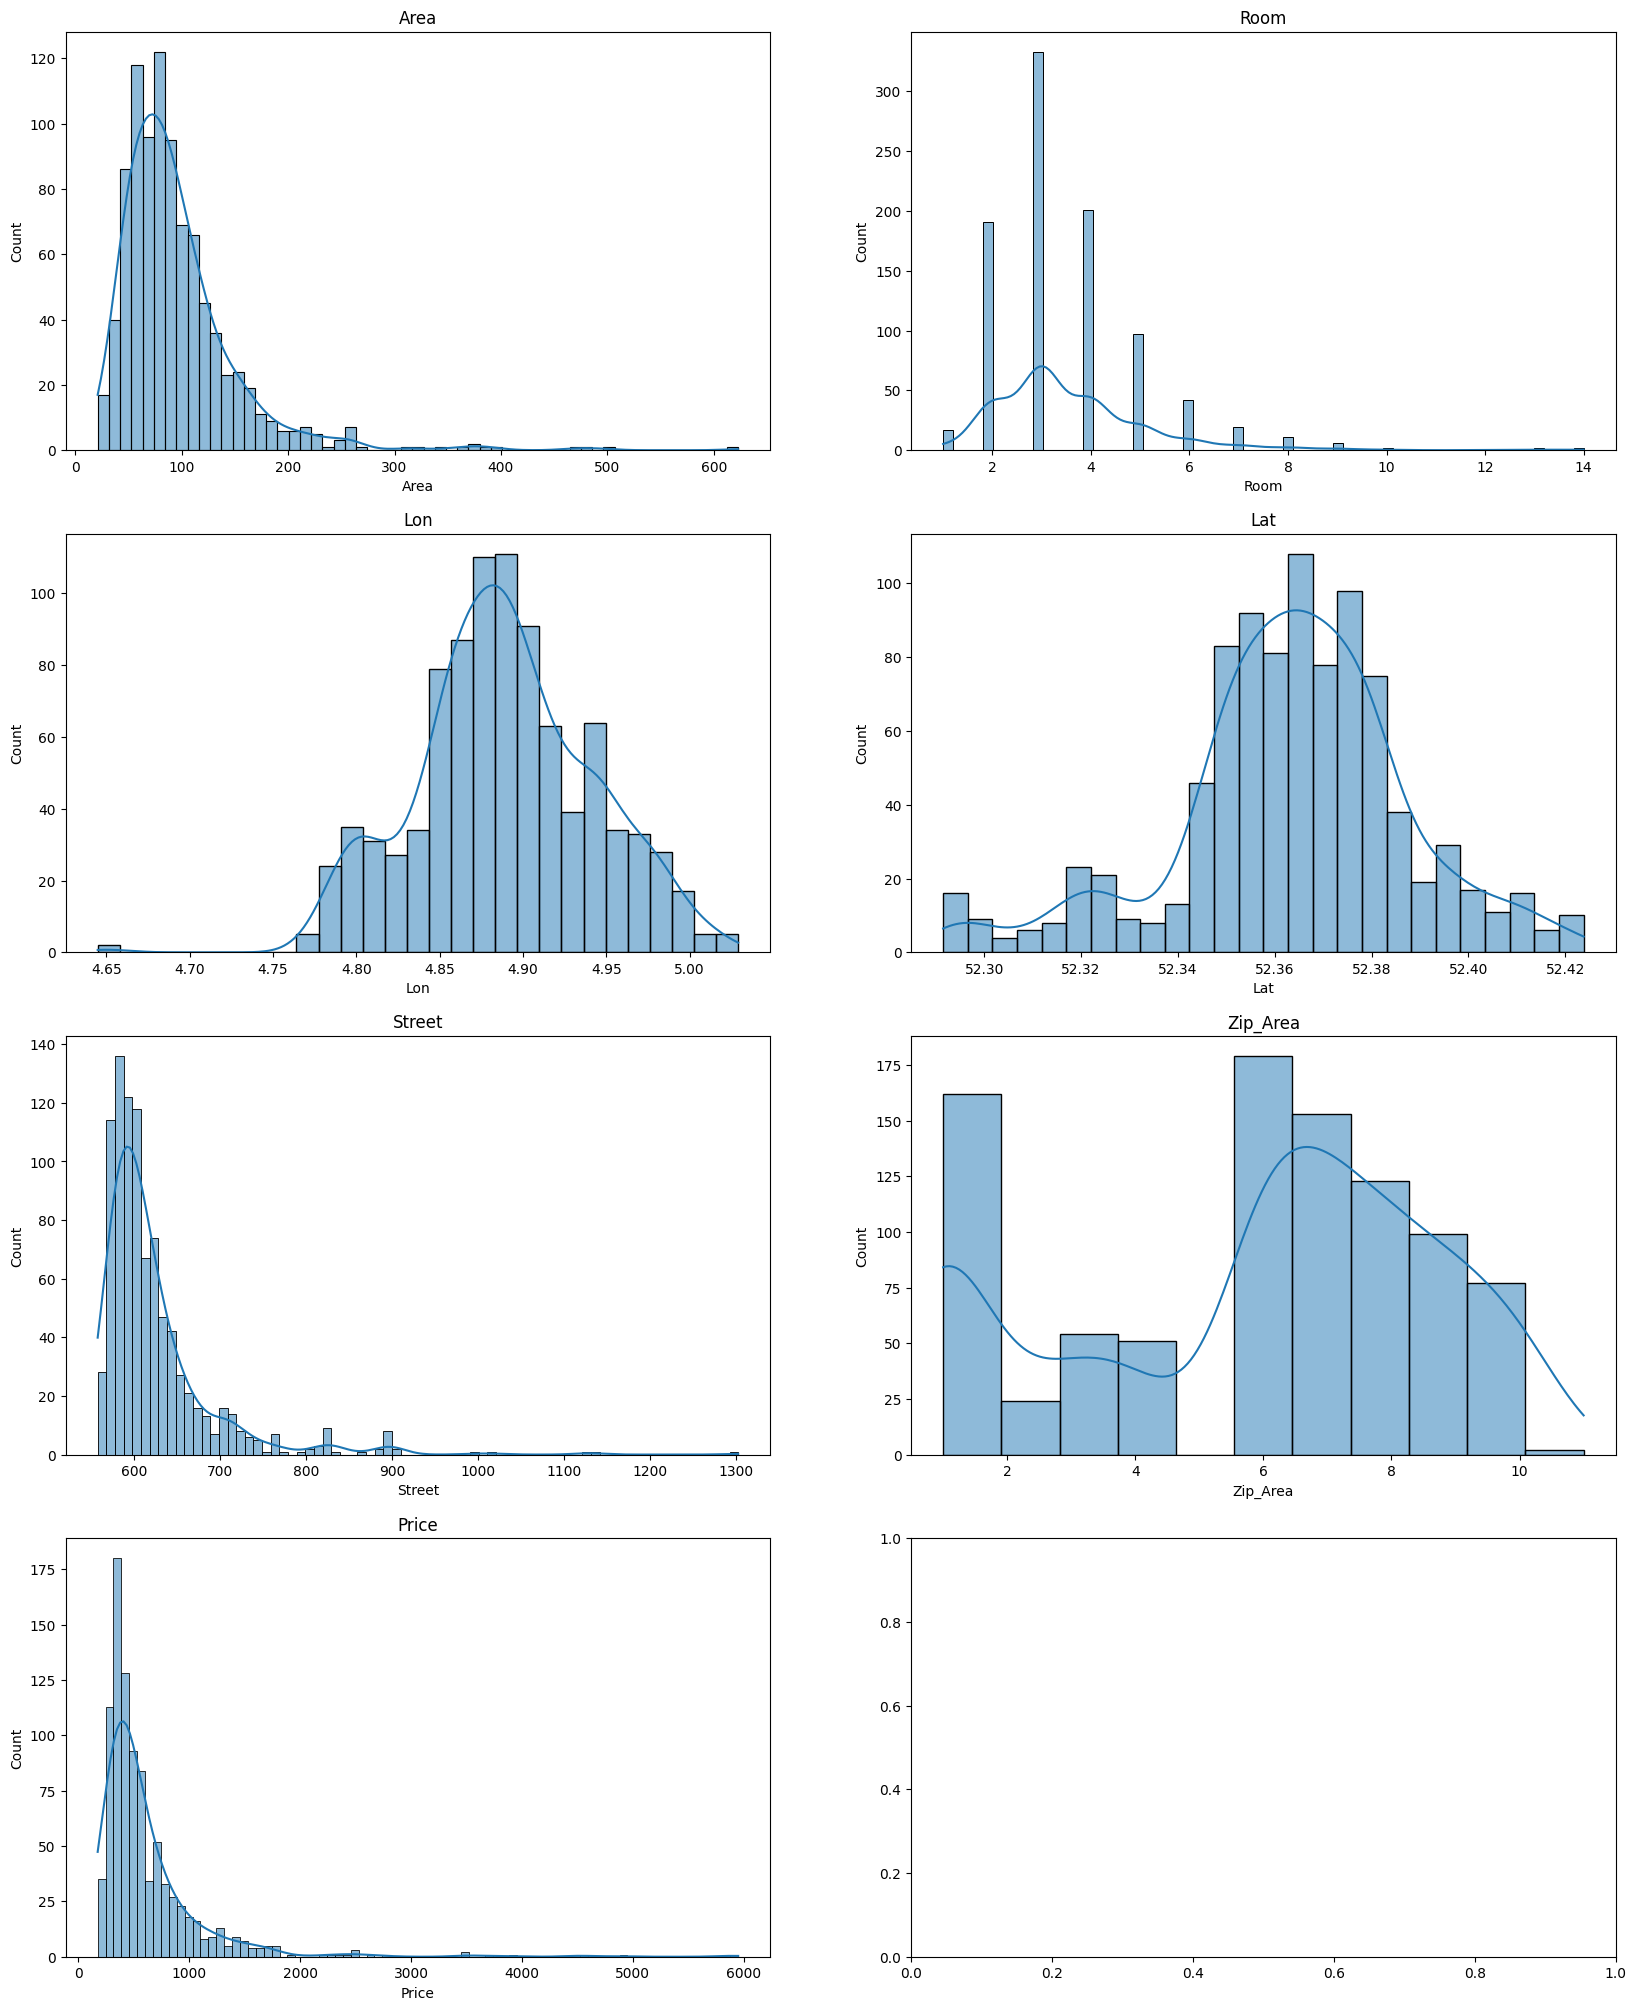

In [274]:
figure, axes = plt.subplots(ceil(len(df.columns)/2), 2, figsize=(20,25))
axes = axes.flatten()
for i, col in enumerate(df.columns):
    sns.histplot(data=df, x=col, kde=True, ax=axes[i])
    axes[i].set_title(col)
plt.show()

[]

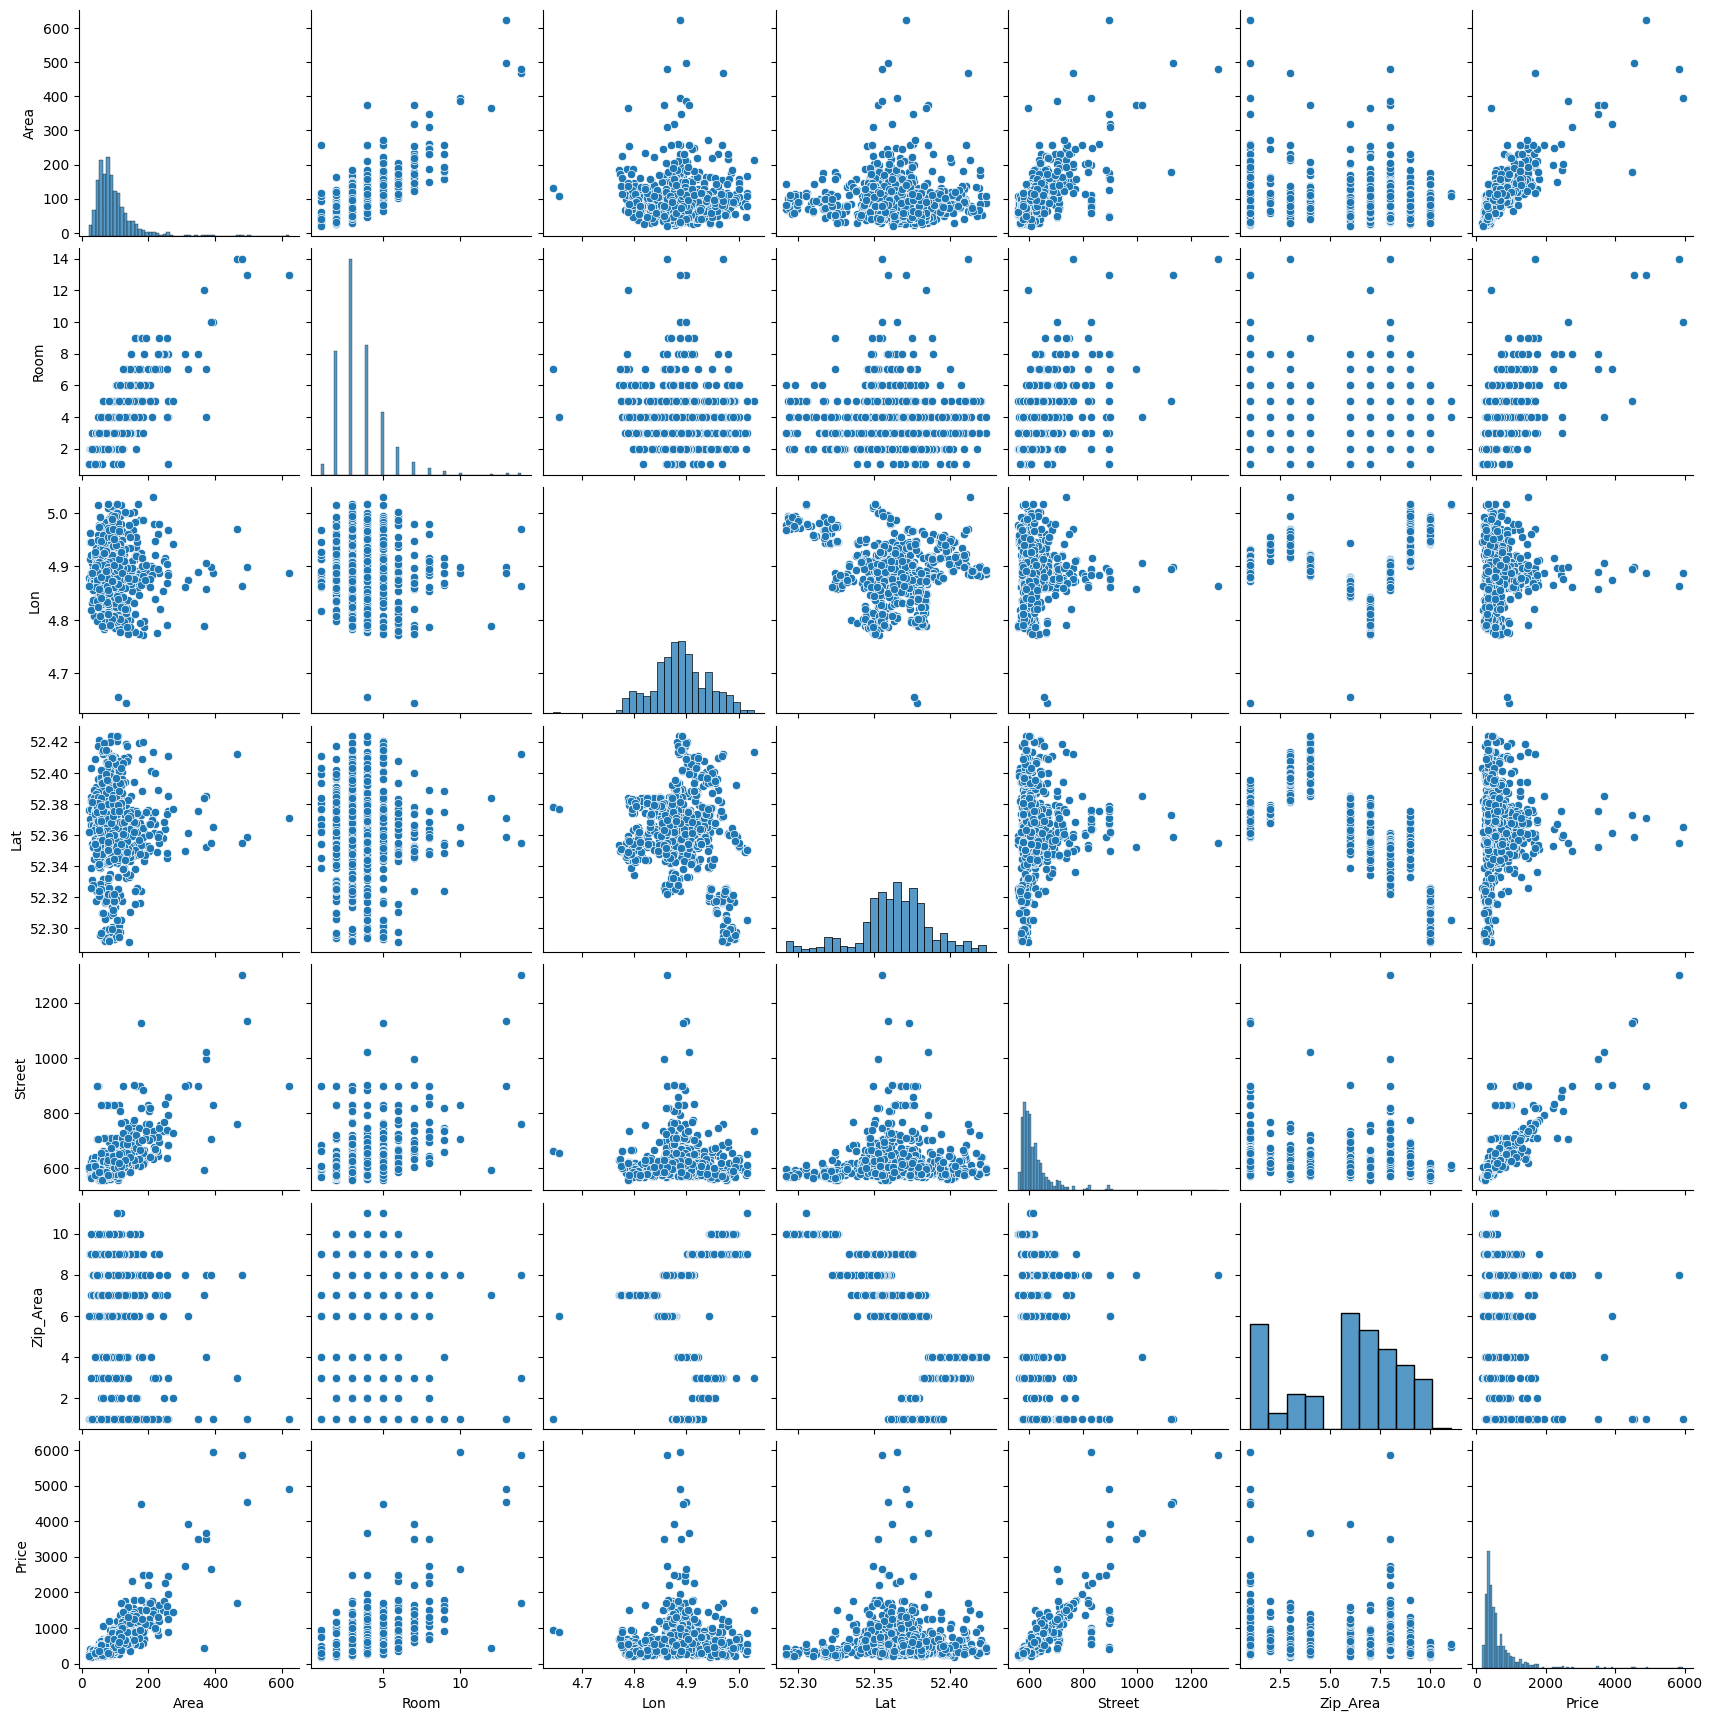

In [275]:
sns.pairplot(df)
plt.plot()

[]

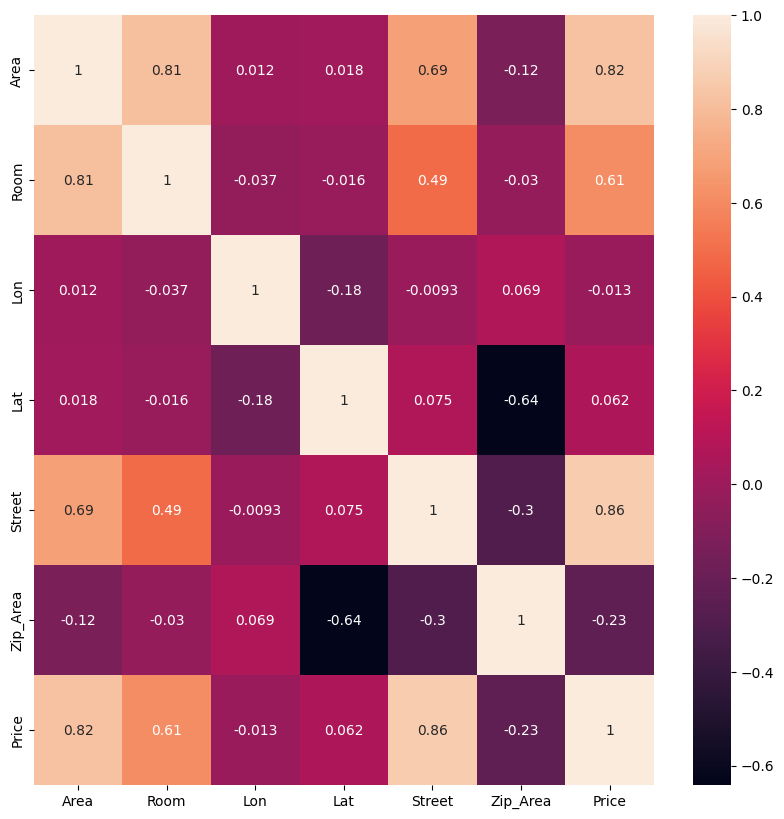

In [276]:
plt.figure(figsize=(10, 10))
sns.heatmap(df.corr(), annot=True)
plt.plot()

### Train and test split

In [277]:
from sklearn.preprocessing import StandardScaler
def prepareDataset(df):
    X = df.iloc[:, :-1]
    y = df.iloc[: , -1]
    
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    return x_train, x_test, y_train, y_test

In [278]:
x_train, x_test, y_train, y_test = prepareDataset(df)

### Random Forest Regressor

In [279]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1500, num = 10)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt', None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 110, num = 22)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


In [280]:
from sklearn.ensemble import RandomForestRegressor
def modelWithBestParams(x_train, x_test, y_train, y_test):

    # RandomizedSearchCV finds best parameters
    rf = RandomForestRegressor(random_state=101)
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=3, random_state=42, n_jobs = -1)
    rf_random.fit(x_train, y_train)
    print("\nBest score: ", rf_random.best_score_)

    best_params = rf_random.best_params_
    print("\nBest parameters: ", best_params)

    # new model is building using best parameters
    rf_model = RandomForestRegressor(**best_params, random_state=101)
    rf_model.fit(x_train, y_train)
    y_pred = rf_model.predict(x_test)

    # Evaluating
    mse = mean_squared_error(y_test, y_pred)
    print(f"\nMean Squared Error: {mse}")
    
    r2 = r2_score(y_test, y_pred)
    print(f"R-squared: {r2}")
    return rf_model

In [281]:
rf_model = modelWithBestParams(x_train, x_test, y_train, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits



Best score:  0.829447158553824

Best parameters:  {'n_estimators': 411, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 25, 'bootstrap': False}

Mean Squared Error: 58016.09273925271
R-squared: 0.8117371396066707


In [282]:
# importance of features
importance_list = list(rf_model.feature_importances_)

feature_imp = [(feature, round(importance, 4)) for feature, importance in zip(df.columns.drop('Price'), importance_list)]
feature_imp = sorted(feature_imp, key= lambda x: x[1], reverse=True)

In [283]:
for feature, importance in feature_imp:
    print(f"{feature:15}: {importance:7}") 

Area           :  0.3931
Street         :  0.3592
Room           :  0.1513
Zip_Area       :  0.0331
Lat            :  0.0321
Lon            :  0.0313


Text(0.5, 1.0, 'Variable Importances')

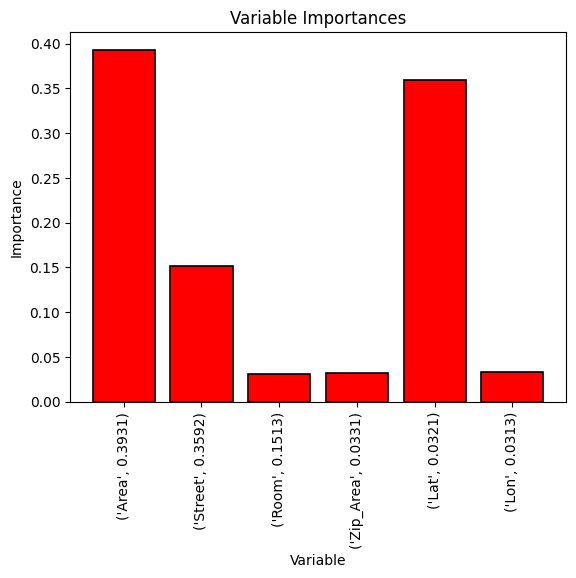

In [284]:
x_values = list(range(len(importance_list)))
plt.bar(x_values, importance_list, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
plt.xticks(x_values, feature_imp, rotation='vertical')
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

In [285]:
df.drop(["Lon", "Lat", "Zip_Area"], axis=1, inplace=True)

x_train, x_test, y_train, y_test = prepareDataset(df)

In [286]:
final_model = modelWithBestParams(x_train, x_test, y_train, y_test)

Fitting 3 folds for each of 100 candidates, totalling 300 fits

Best score:  0.8453973874867815

Best parameters:  {'n_estimators': 722, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}

Mean Squared Error: 51298.79468354767
R-squared: 0.8335348458356178
